In [1]:
# Cell 1: Imports and Setup for Task2

import os
import ssl
import json
import nltk
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModel, BertTokenizer, BertModel
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# Download required NLTK resources
nltk.download("punkt")

# Set device (Kaggle typically provides CUDA; this will use GPU if available)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define a global label mapping and number of labels
label_map = {"positive": 2, "neutral": 1, "negative": 0}
num_labels = len(label_map)
print(num_labels)

# Initialize BERT tokenizer & model for embeddings (used in both training and evaluation)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased").to(device)
bert_model.eval()

# Define a helper function to get BERT embeddings
def get_bert_embedding(text):
    inputs = tokenizer(
        text, return_tensors="pt", truncation=True, padding="max_length", max_length=30
    ).to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    # Mean pooling over sequence length
    return outputs.last_hidden_state.mean(dim=1).squeeze(0)


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using device: cuda:1
3


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [2]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [3]:
!pip uninstall -y wandb


Found existing installation: wandb 0.19.1
Uninstalling wandb-0.19.1:
  Successfully uninstalled wandb-0.19.1


In [4]:
pip install git+https://github.com/kmkurn/pytorch-crf.git


  Cloning https://github.com/kmkurn/pytorch-crf.git to /tmp/pip-req-build-ov00ekq9
  Running command git clone --filter=blob:none --quiet https://github.com/kmkurn/pytorch-crf.git /tmp/pip-req-build-ov00ekq9
  Resolved https://github.com/kmkurn/pytorch-crf.git to commit 623e3402d00a2728e99d6e8486010d67c754267b
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-crf: filename=pytorch_crf-0.7.2-py3-none-any.whl size=6410 sha256=70bdb13e3dcb2f1dff4dcc3e88ca889ba6f3dc143f157c433a62a274913fbdc6
  Stored in directory: /tmp/pip-ephem-wheel-cache-jo4udcgi/wheels/39/5f/f6/4b48b35895d914f4f5fff5b600f87658c11693e37b6a4f118e
Successfully built pytorch-crf
Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip uninstall -y torchcrf

In [6]:
!pip install torchcrf

In [7]:
# !rm -rf /kaggle/working/out



In [8]:
# %% [markdown]
# ## Cell 2: Data Preprocessing & JSON File Generation
# This function processes the ABSA data, extracting tokens, aspect term, its index and sentiment label.

from nltk.tokenize import word_tokenize

def process_absa_data(input_file, output_file, is_test=False):
    """Loads, preprocesses, and saves ABSA data."""
    with open(input_file, "r", encoding="utf-8") as f:
        data = json.load(f)

    formatted_data = []
    for entry in data:
        sentence = entry.get("sentence", "")
        tokens = word_tokenize(sentence)
        if not tokens:
            continue

        for aspect in entry.get("aspect_terms", []):
            aspect_term = aspect["term"]
            aspect_tokens = word_tokenize(aspect_term)
            # Find the index of the first token; if not found, skip
            if aspect_tokens[0] not in tokens:
                continue
            index = tokens.index(aspect_tokens[0])
            formatted_entry = {
                "tokens": tokens,
                "aspect_term": aspect_term,
                "index": index,
                "label": label_map.get(aspect.get("polarity", "neutral"), 1)
                if not is_test
                else None,
            }
            formatted_data.append(formatted_entry)

    # Save the preprocessed data
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(formatted_data, f, indent=4, ensure_ascii=False)

    print(f" Processed data saved to {output_file}")
    return formatted_data

# Process training and validation data (ensure 'train.json' and 'val.json' are available in your working directory)
train_data = process_absa_data("/kaggle/input/aspect-based-sentiment-analysis/train.json", "train_task_2.json")
val_data = process_absa_data("/kaggle/input/aspect-based-sentiment-analysis/val.json", "val_task_2.json")
test_data = process_absa_data("/kaggle/input/aspect-based-sentiment-analysis/test.json", "test_task_2.json", is_test=True)


✅ Processed data saved to train_task_2.json
✅ Processed data saved to val_task_2.json
✅ Processed data saved to test_task_2.json


In [9]:
# Print sample information for train, validation, and test datasets
print("\n=== Train Data Sample ===")
if train_data:
    print("Keys:", list(train_data[0].keys()))
    print("Sample:", train_data[0])
else:
    print("No train data found.")

print("\n=== Validation Data Sample ===")
if val_data:
    print("Keys:", list(val_data[0].keys()))
    print("Sample:", val_data[0])
else:
    print("No validation data found.")

print("\n=== Test Data Sample ===")
if test_data:
    print("Keys:", list(test_data[0].keys()))
    print("Sample:", test_data[0])
else:
    print("No test data found.")


=== Train Data Sample ===
Keys: ['tokens', 'aspect_term', 'index', 'label']
Sample: {'tokens': ['But', 'the', 'staff', 'was', 'so', 'horrible', 'to', 'us', '.'], 'aspect_term': 'staff', 'index': 2, 'label': 0}

=== Validation Data Sample ===
Keys: ['tokens', 'aspect_term', 'index', 'label']
Sample: {'tokens': ['I', 'was', 'here', 'a', 'few', 'weeks', 'back', 'and', 'we', 'had', 'the', 'worst', 'customer', 'service', 'experience', 'at', 'a', 'restaurant', 'ever', '.'], 'aspect_term': 'customer service', 'index': 12, 'label': 0}

=== Test Data Sample ===
Keys: ['tokens', 'aspect_term', 'index', 'label']
Sample: {'tokens': ['The', 'service', 'was', 'exceptional', ',', 'but', 'the', 'food', 'was', 'bland', 'and', 'overpriced', '.'], 'aspect_term': 'service', 'index': 1, 'label': None}


In [10]:
# %% [markdown]
# ## Cell 3: Dataset and DataLoader Setup

from collections import Counter
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# Create a PyTorch Dataset for ABSA data
class ABSADataset(Dataset):
    def __init__(self, data):
        self.data = [item for item in data if item]
        print(f"Dataset initialized with {len(self.data)} samples.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        sentence = " ".join(item["tokens"])
        aspect_term = item["aspect_term"]
        index = item["index"]
        label = item.get("label", None)

        # Debug prints
        print(f"\nProcessing sample {idx}:")
        print(f"Sentence: {sentence}")
        print(f"Aspect Term: {aspect_term}")
        print(f"Index: {index}")
        print(f"Label: {label}")

        # Get embeddings using our helper function
        sentence_embedding = get_bert_embedding(sentence).cpu()
        aspect_embedding = get_bert_embedding(aspect_term).cpu()

        print(f"Sentence Embedding Shape: {sentence_embedding.shape}")
        print(f"Aspect Embedding Shape: {aspect_embedding.shape}")

        return (
            sentence_embedding,
            aspect_embedding,
            torch.tensor(index),
            torch.tensor(label) if label is not None else None,
        )

# Compute class distribution for weighted sampling
train_labels = [item["label"] for item in train_data if item["label"] is not None]
label_counts = Counter(train_labels)
print("# ----------------------------")
print("\nClass Distribution:")
for label, count in label_counts.items():
    print(f"Label {label}: {count} samples")

class_weights = torch.tensor(
    [1.0 / label_counts[i] if i in label_counts else 0.0 for i in range(num_labels)],
    dtype=torch.float32,
).to(device)

# Print class weights
print("# ----------------------------")
print("\nClass Weights:")
for i, weight in enumerate(class_weights.cpu().numpy()):
    print(f"Label {i}: {weight:.6f}")

# Create WeightedRandomSampler
sample_weights = [class_weights[label].item() for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

print("\nSample Weights:", sample_weights[:10])  # Print first 10 sample weights

# Create Dataset and DataLoader objects
train_dataset = ABSADataset(train_data)
val_dataset = ABSADataset(val_data)

train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print("\nDataloaders created successfully!")
print(f"Train DataLoader: {len(train_loader)} batches")
print(f"Validation DataLoader: {len(val_loader)} batches")


Class Distribution: Counter({2: 1733, 0: 661, 1: 560})


In [11]:
# %% [markdown]
# ## Cell 4: Model Definition (BiLSTM with Aspect Attention)

class BiLSTMWithAspectAttention(nn.Module):
    def __init__(self, embedding_dim=768, hidden_dim=96, output_dim=num_labels):
        super(BiLSTMWithAspectAttention, self).__init__()

        # Input dropout
        self.input_dropout = nn.Dropout(0.2)

        # LSTM layer with dropout
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=1,
            bidirectional=True,
            batch_first=True,
            dropout=0.2,
        )

        # Batch normalization layer
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)

        self.aspect_fc = nn.Linear(embedding_dim, hidden_dim * 2)
        self.attention = nn.Linear(hidden_dim * 2, 1)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

        # Dropouts for fully connected layers
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, aspect_embedding, index):
        # Apply input dropout
        x = self.input_dropout(x)
        aspect_embedding = self.input_dropout(aspect_embedding)

        # LSTM layer (unsqueeze to add sequence dimension)
        lstm_out, _ = self.lstm(x.unsqueeze(1))
        # Remove sequence dimension and apply batch norm
        lstm_out = self.batch_norm(lstm_out.squeeze(1))

        # Aspect attention: combine LSTM output with aspect embedding
        aspect_transformed = self.aspect_fc(aspect_embedding)
        attention_weights = torch.tanh(self.attention(lstm_out + aspect_transformed))
        attention_weights = torch.softmax(attention_weights, dim=1)
        attended_representation = torch.sum(attention_weights * lstm_out.unsqueeze(1), dim=1)

        # Fully connected layers with dropouts
        x = self.dropout1(attended_representation)
        x = torch.relu(self.fc1(x))
        x = self.dropout2(x)
        output = self.fc2(x)

        return self.softmax(output)


In [18]:
# Training Loop with Early Stopping

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import json
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix

def train_model(model, train_loader, val_loader, epochs=10):
    """Train the ABSA model with early stopping and performance tracking."""
    
    best_val_acc = 0.0
    best_model_state = None
    patience = 5  # Number of epochs to wait before stopping if no improvement
    patience_counter = 0

    # Initialize metrics tracking
    metrics = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
        "confusion_matrix": None,
        "f1_scores": None,
    }
    print("# ----------------------------")
    print("\n Starting training...\n")
    print("# ----------------------------")
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        train_preds, train_labels_list = [], []

        print(f"\n Epoch {epoch + 1}/{epochs} - Training")

        for sentence_embedding, aspect_embedding, index, labels in tqdm(train_loader, desc="Training Batch Progress"):
            sentence_embedding, aspect_embedding, labels = (
                sentence_embedding.to(device),
                aspect_embedding.to(device),
                labels.to(device),
            )

            optimizer.zero_grad()
            outputs = model(sentence_embedding, aspect_embedding, index)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Prevent exploding gradients
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            train_preds.extend(preds.cpu().numpy())
            train_labels_list.extend(labels.cpu().numpy())

        # Compute training loss and accuracy
        train_loss = total_loss / len(train_loader)
        train_acc = correct / total
        metrics["train_loss"].append(train_loss)
        metrics["train_acc"].append(train_acc)

        print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}")

        # ---------------------
        # VALIDATION PHASE
        # ---------------------
        model.eval()
        val_correct, val_total, val_loss = 0, 0, 0.0
        val_preds, val_labels_list = [], []

        print(f"\n Epoch {epoch + 1} - Validation")

        with torch.no_grad():
            for sentence_embedding, aspect_embedding, index, labels in val_loader:
                sentence_embedding, aspect_embedding, labels = (
                    sentence_embedding.to(device),
                    aspect_embedding.to(device),
                    labels.to(device),
                )

                outputs = model(sentence_embedding, aspect_embedding, index)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

                val_preds.extend(preds.cpu().numpy())
                val_labels_list.extend(labels.cpu().numpy())

        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        metrics["val_loss"].append(val_loss)
        metrics["val_acc"].append(val_acc)

        print(f"📊 Epoch {epoch + 1}: Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")

        # Adjust learning rate based on validation loss
        scheduler.step(val_loss)

        # ---------------------
        # EARLY STOPPING LOGIC
        # ---------------------
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0  # Reset patience if performance improves
            print(" New best model found! Saving checkpoint...")
        else:
            patience_counter += 1
            print(f"No improvement. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"\n Early stopping triggered after {epoch + 1} epochs.\n")
            model.load_state_dict(best_model_state)
            break

   
    # print("# ----------------------------")
    print("\n Final Metrics Computation...")
    print("# ----------------------------")

    val_preds_np = np.array(val_preds)
    val_labels_np = np.array(val_labels_list)
    f1_scores = f1_score(val_labels_np, val_preds_np, average=None)
    metrics["f1_scores"] = f1_scores.tolist()
    cm = confusion_matrix(val_labels_np, val_preds_np)
    metrics["confusion_matrix"] = cm.tolist()

    print("\n F1 Scores per class:", f1_scores)
    print("\n Confusion Matrix:\n", cm)


    # print("# ----------------------------")
    print("\n Saving best model and training metrics...")
    # print("# ----------------------------")
    torch.save(model.state_dict(), "best_model.pt")
    with open("training_metrics.json", "w") as f:
        json.dump(metrics, f, indent=4)

    print("\n Training completed!\n")
    return model, metrics

# print("# ----------------------------")
print("INITIALIZE MODEL, LOSS, OPTIMIZER")
print("# ----------------------------")
model = BiLSTMWithAspectAttention().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=0.05)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2, verbose=True)

# Train the model
model, metrics = train_model(model, train_loader, val_loader, epochs=5)


INITIALIZE MODEL, LOSS, OPTIMIZER
# ----------------------------
# ----------------------------

 Starting training...

# ----------------------------

 Epoch 1/5 - Training


Training Batch Progress: 100%|██████████| 370/370 [00:50<00:00,  7.29it/s]


Epoch 1: Train Loss = 1.0145, Train Acc = 0.4719

 Epoch 1 - Validation
📊 Epoch 1: Val Loss = 0.9773, Val Acc = 0.5418
 New best model found! Saving checkpoint...

 Epoch 2/5 - Training


Training Batch Progress: 100%|██████████| 370/370 [00:50<00:00,  7.29it/s]


Epoch 2: Train Loss = 0.9421, Train Acc = 0.5613

 Epoch 2 - Validation
📊 Epoch 2: Val Loss = 0.9642, Val Acc = 0.5580
 New best model found! Saving checkpoint...

 Epoch 3/5 - Training


Training Batch Progress: 100%|██████████| 370/370 [00:50<00:00,  7.27it/s]


Epoch 3: Train Loss = 0.9110, Train Acc = 0.6002

 Epoch 3 - Validation
📊 Epoch 3: Val Loss = 0.9385, Val Acc = 0.6253
 New best model found! Saving checkpoint...

 Epoch 4/5 - Training


Training Batch Progress: 100%|██████████| 370/370 [00:51<00:00,  7.24it/s]


Epoch 4: Train Loss = 0.9021, Train Acc = 0.6222

 Epoch 4 - Validation
📊 Epoch 4: Val Loss = 0.9405, Val Acc = 0.6119
No improvement. Patience: 1/5

 Epoch 5/5 - Training


Training Batch Progress: 100%|██████████| 370/370 [00:51<00:00,  7.24it/s]


Epoch 5: Train Loss = 0.8900, Train Acc = 0.6405

 Epoch 5 - Validation
📊 Epoch 5: Val Loss = 0.9622, Val Acc = 0.5310
No improvement. Patience: 2/5

 Final Metrics Computation...
# ----------------------------

 F1 Scores per class: [0.56976744 0.43283582 0.59602649]

 Confusion Matrix:
 [[49 25  0]
 [27 58  5]
 [22 95 90]]

 Saving best model and training metrics...

 Training completed!



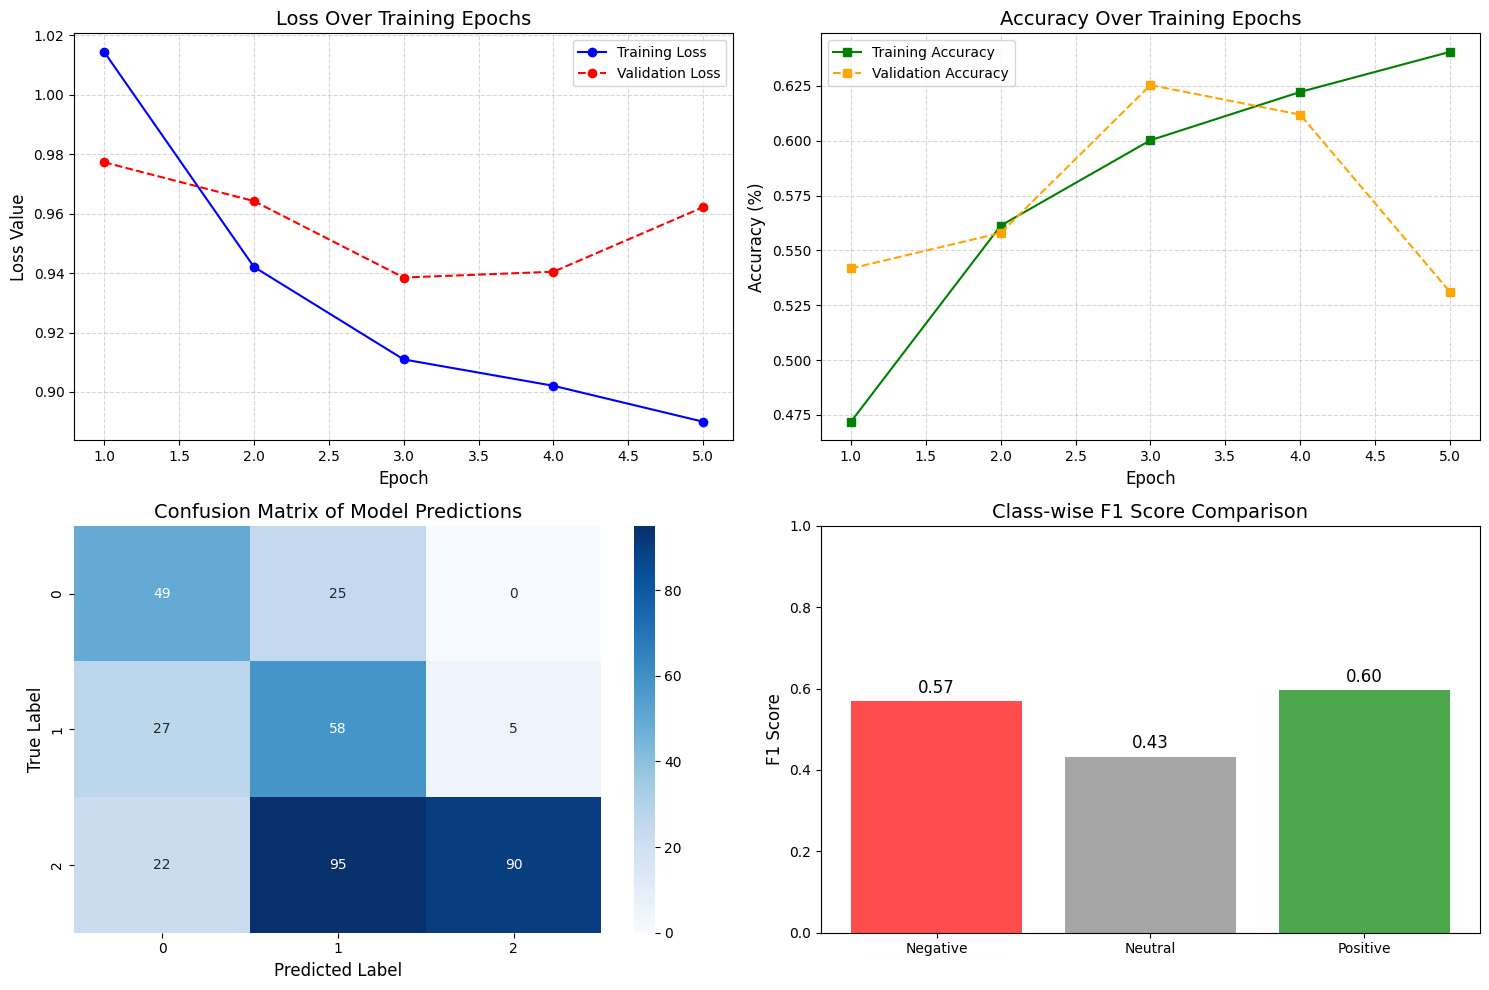

In [19]:
# %% [markdown]
# ## Cell 6: Plot Training Metrics

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_metrics(metrics):
    """
    Visualizing the model performance over epochs using training loss, accuracy, 
    confusion matrix, and F1 scores.
    """

    epochs = range(1, len(metrics["train_loss"]) + 1)
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # ---------------------------
    # Plot 1: Training & Validation Loss
    # ---------------------------
    axs[0, 0].plot(epochs, metrics["train_loss"], marker="o", linestyle="-", label="Training Loss", color="blue")
    axs[0, 0].plot(epochs, metrics["val_loss"], marker="o", linestyle="--", label="Validation Loss", color="red")
    axs[0, 0].set_title("Loss Over Training Epochs", fontsize=14)
    axs[0, 0].set_xlabel("Epoch", fontsize=12)
    axs[0, 0].set_ylabel("Loss Value", fontsize=12)
    axs[0, 0].legend()
    axs[0, 0].grid(True, linestyle="--", alpha=0.5)

    # ---------------------------
    # Plot 2: Training & Validation Accuracy
    # ---------------------------
    axs[0, 1].plot(epochs, metrics["train_acc"], marker="s", linestyle="-", label="Training Accuracy", color="green")
    axs[0, 1].plot(epochs, metrics["val_acc"], marker="s", linestyle="--", label="Validation Accuracy", color="orange")
    axs[0, 1].set_title("Accuracy Over Training Epochs", fontsize=14)
    axs[0, 1].set_xlabel("Epoch", fontsize=12)
    axs[0, 1].set_ylabel("Accuracy (%)", fontsize=12)
    axs[0, 1].legend()
    axs[0, 1].grid(True, linestyle="--", alpha=0.5)

    # ---------------------------
    # Plot 3: Confusion Matrix
    # ---------------------------
    if metrics["confusion_matrix"] is not None:
        cm = np.array(metrics["confusion_matrix"])
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axs[1, 0])
        axs[1, 0].set_title("Confusion Matrix of Model Predictions", fontsize=14)
        axs[1, 0].set_xlabel("Predicted Label", fontsize=12)
        axs[1, 0].set_ylabel("True Label", fontsize=12)

    # ---------------------------
    # Plot 4: F1 Score Per Class
    # ---------------------------
    if metrics["f1_scores"] is not None:
        f1_scores = metrics["f1_scores"]
        class_labels = ["Negative", "Neutral", "Positive"]
        axs[1, 1].bar(class_labels, f1_scores, color=["red", "gray", "green"], alpha=0.7)
        axs[1, 1].set_title("Class-wise F1 Score Comparison", fontsize=14)
        axs[1, 1].set_ylim(0, 1)
        axs[1, 1].set_ylabel("F1 Score", fontsize=12)
        for i, v in enumerate(f1_scores):
            axs[1, 1].text(i, v + 0.02, f"{v:.2f}", ha="center", fontsize=12)

    plt.tight_layout()
    plt.show()

# Call the function to visualize training metrics
plot_metrics(metrics)


In [ ]:
import warnings
warnings.filterwarnings("ignore")


In [20]:
import json
import torch
import numpy as np
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import f1_score

# Global variables
num_labels = 3  # Adjust if necessary
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Define a dataset for Hugging Face Trainer
class HFABSA_Dataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
        print(f"HFABSA_Dataset initialized with {len(self.data)} samples.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        sentence = " ".join(item["tokens"])
        label = item["label"]
        encoding = self.tokenizer(
            sentence,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)
        # Uncomment the following lines to debug the first sample only
        # if idx == 0:
        #     print("Sample 0 - input_ids shape:", input_ids.shape)
        #     print("Sample 0 - attention_mask shape:", attention_mask.shape)
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": torch.tensor(label, dtype=torch.long)
        }

def compute_metrics(eval_pred):
    print("Computing evaluation metrics...")
    predictions = eval_pred.predictions
    labels = eval_pred.label_ids

    # If predictions come as a tuple, assume logits are the second element
    if isinstance(predictions, tuple):
        logits = predictions[1]
    else:
        logits = predictions

    logits = np.array(logits, dtype=np.float32)
    aggregated_logits = []
    for i, log in enumerate(logits):
        log = np.array(log)
        if log.ndim == 1 and log.shape[0] == num_labels:
            agg = log
        elif log.ndim == 2:
            agg = log.mean(axis=0)
        elif log.ndim > 2:
            agg = log.reshape(-1, log.shape[-1]).mean(axis=0)
        else:
            agg = np.zeros(num_labels)
        if agg.shape[0] != num_labels:
            if agg.shape[0] > num_labels:
                agg = agg[:num_labels]
            else:
                agg = np.pad(agg, (0, num_labels - agg.shape[0]), constant_values=0)
        aggregated_logits.append(agg)

    logits_arr = np.vstack(aggregated_logits)
    preds = np.argmax(logits_arr, axis=1)
    acc = (preds == labels).mean()
    f1 = f1_score(labels, preds, average="macro")
    print("Computed metrics - Accuracy:", acc, "F1 Score:", f1)
    return {"accuracy": acc, "f1": f1}

def fine_tune_transformer(model_name, train_data, val_data, epochs=5):
    print(f"\nStarting fine-tuning for model: {model_name}")
    print(f"Number of epochs set to: {epochs}")
    
    # Load tokenizer and initialize datasets
    tokenizer_hf = AutoTokenizer.from_pretrained(model_name)
    print("Tokenizer loaded for", model_name)
    train_dataset = HFABSA_Dataset(train_data, tokenizer_hf)
    val_dataset = HFABSA_Dataset(val_data, tokenizer_hf)
    print(f"Train dataset size: {len(train_dataset)}; Validation dataset size: {len(val_dataset)}")
    
    # Load model with a classification head
    model_hf = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
        problem_type="single_label_classification"
    ).to(device)
    print("Model loaded and moved to", device)
    
    # Set up training arguments
    training_args = TrainingArguments(
        output_dir=f"{model_name}-finetuned",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        num_train_epochs=epochs,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        load_best_model_at_end=True,
        save_total_limit=1,
        logging_dir=f"{model_name}-logs",
    )
    print("Training arguments set. Beginning Trainer setup...")
    
    # Initialize the Trainer
    trainer = Trainer(
        model=model_hf,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )
    
    print("Starting training...")
    trainer.train()
    print("Training completed.")
    
    print("Evaluating the fine-tuned model...")
    eval_metrics = trainer.evaluate()
    print("Evaluation metrics:", eval_metrics)
    
    trainer.save_model(f"{model_name}-best")
    print(f"Model saved to {model_name}-best")
    
    return trainer.state.log_history, eval_metrics


Device: cuda:1


In [22]:
# Fine-tune transformer models 
bert_logs, bert_eval_metrics = fine_tune_transformer("bert-base-uncased", train_data, val_data, epochs=5)

print("Transformer fine-tuning completed!")
print("BERT Eval Metrics:", bert_eval_metrics)



Starting fine-tuning for model: bert-base-uncased
Number of epochs set to: 5
Tokenizer loaded for bert-base-uncased
HFABSA_Dataset initialized with 2954 samples.
HFABSA_Dataset initialized with 371 samples.
Train dataset size: 2954; Validation dataset size: 371


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Model loaded and moved to cuda:1
Training arguments set. Beginning Trainer setup...
Starting training...


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.722500,0.684120,0.700809,0.616251
2,0.531100,0.679351,0.719677,0.641556
3,0.417000,0.655368,0.706199,0.642290
4,0.336900,0.643572,0.735849,0.707491
5,0.278100,0.660913,0.719677,0.649841


Computing evaluation metrics...
Computed metrics - Accuracy: 0.7008086253369272 F1 Score: 0.6162506647550366


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Computing evaluation metrics...
Computed metrics - Accuracy: 0.7196765498652291 F1 Score: 0.6415558384848624


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Computing evaluation metrics...
Computed metrics - Accuracy: 0.706199460916442 F1 Score: 0.6422896922896922


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Computing evaluation metrics...
Computed metrics - Accuracy: 0.7358490566037735 F1 Score: 0.7074912090440041


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Computing evaluation metrics...
Computed metrics - Accuracy: 0.7196765498652291 F1 Score: 0.6498407880947633
Training completed.
Evaluating the fine-tuned model...


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Computing evaluation metrics...
Computed metrics - Accuracy: 0.7358490566037735 F1 Score: 0.7074912090440041
Evaluation metrics: {'eval_loss': 0.6435721516609192, 'eval_accuracy': 0.7358490566037735, 'eval_f1': 0.7074912090440041, 'eval_runtime': 2.2709, 'eval_samples_per_second': 163.37, 'eval_steps_per_second': 10.568, 'epoch': 5.0}
Model saved to bert-base-uncased-best
Transformer fine-tuning completed!
BERT Eval Metrics: {'eval_loss': 0.6435721516609192, 'eval_accuracy': 0.7358490566037735, 'eval_f1': 0.7074912090440041, 'eval_runtime': 2.2709, 'eval_samples_per_second': 163.37, 'eval_steps_per_second': 10.568, 'epoch': 5.0}


In [23]:
# Fine-tune transformer models 
roberta_logs, roberta_eval_metrics = fine_tune_transformer("roberta-base", train_data, val_data, epochs=5)
print("Transformer fine-tuning completed!")
print("RoBERTa Eval Metrics:", roberta_eval_metrics)


Starting fine-tuning for model: roberta-base
Number of epochs set to: 5


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Tokenizer loaded for roberta-base
HFABSA_Dataset initialized with 2954 samples.
HFABSA_Dataset initialized with 371 samples.
Train dataset size: 2954; Validation dataset size: 371


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Model loaded and moved to cuda:1
Training arguments set. Beginning Trainer setup...
Starting training...


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.758800,0.757752,0.660377,0.518815
2,0.611300,0.715300,0.727763,0.669861
3,0.487200,0.726172,0.657682,0.585058
4,0.397200,0.727350,0.684636,0.592805
5,0.332700,0.825989,0.700809,0.615966


Computing evaluation metrics...
Computed metrics - Accuracy: 0.660377358490566 F1 Score: 0.5188148099516832


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Computing evaluation metrics...
Computed metrics - Accuracy: 0.7277628032345014 F1 Score: 0.66986116249757


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Computing evaluation metrics...
Computed metrics - Accuracy: 0.6576819407008087 F1 Score: 0.5850575356977176


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Computing evaluation metrics...
Computed metrics - Accuracy: 0.6846361185983828 F1 Score: 0.5928051363648161


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Computing evaluation metrics...
Computed metrics - Accuracy: 0.7008086253369272 F1 Score: 0.6159656931587979
Training completed.
Evaluating the fine-tuned model...


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Computing evaluation metrics...
Computed metrics - Accuracy: 0.7277628032345014 F1 Score: 0.66986116249757
Evaluation metrics: {'eval_loss': 0.7152996063232422, 'eval_accuracy': 0.7277628032345014, 'eval_f1': 0.66986116249757, 'eval_runtime': 2.3396, 'eval_samples_per_second': 158.576, 'eval_steps_per_second': 10.258, 'epoch': 5.0}
Model saved to roberta-base-best
Transformer fine-tuning completed!
RoBERTa Eval Metrics: {'eval_loss': 0.7152996063232422, 'eval_accuracy': 0.7277628032345014, 'eval_f1': 0.66986116249757, 'eval_runtime': 2.3396, 'eval_samples_per_second': 158.576, 'eval_steps_per_second': 10.258, 'epoch': 5.0}


In [24]:
# Fine-tune transformer models 
bart_logs, bart_eval_metrics = fine_tune_transformer("facebook/bart-large-mnli", train_data, val_data, epochs=5)

print("Transformer fine-tuning completed!")
print("BART Eval Metrics:", bart_eval_metrics)



Starting fine-tuning for model: facebook/bart-large-mnli
Number of epochs set to: 5


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Tokenizer loaded for facebook/bart-large-mnli
HFABSA_Dataset initialized with 2954 samples.
HFABSA_Dataset initialized with 371 samples.
Train dataset size: 2954; Validation dataset size: 371


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Model loaded and moved to cuda:1
Training arguments set. Beginning Trainer setup...
Starting training...


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.728000,0.670251,0.242588,0.130152
2,0.526600,0.713504,0.223720,0.124906
3,0.421900,0.857464,0.242588,0.132159
4,0.360000,0.751754,0.242588,0.130152
5,0.285000,0.827962,0.223720,0.124906


Computing evaluation metrics...
Computed metrics - Accuracy: 0.24258760107816713 F1 Score: 0.1301518438177874


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Computing evaluation metrics...
Computed metrics - Accuracy: 0.22371967654986524 F1 Score: 0.12490594431903686


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Computing evaluation metrics...
Computed metrics - Accuracy: 0.24258760107816713 F1 Score: 0.13215859030837004


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Computing evaluation metrics...
Computed metrics - Accuracy: 0.24258760107816713 F1 Score: 0.1301518438177874


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Computing evaluation metrics...
Computed metrics - Accuracy: 0.22371967654986524 F1 Score: 0.12490594431903686


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight'].


Training completed.
Evaluating the fine-tuned model...


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Computing evaluation metrics...
Computed metrics - Accuracy: 0.24258760107816713 F1 Score: 0.1301518438177874
Evaluation metrics: {'eval_loss': 0.6702509522438049, 'eval_accuracy': 0.24258760107816713, 'eval_f1': 0.1301518438177874, 'eval_runtime': 10.7897, 'eval_samples_per_second': 34.385, 'eval_steps_per_second': 2.224, 'epoch': 5.0}
Model saved to facebook/bart-large-mnli-best
Transformer fine-tuning completed!
BART Eval Metrics: {'eval_loss': 0.6702509522438049, 'eval_accuracy': 0.24258760107816713, 'eval_f1': 0.1301518438177874, 'eval_runtime': 10.7897, 'eval_samples_per_second': 34.385, 'eval_steps_per_second': 2.224, 'epoch': 5.0}


In [25]:
model, bilstm_metrics = train_model(model, train_loader, val_loader, epochs=5)
print("BiLSTM Validation Accuracy:", bilstm_metrics["val_acc"][-1])


# ----------------------------

 Starting training...

# ----------------------------

 Epoch 1/5 - Training


Training Batch Progress: 100%|██████████| 370/370 [00:52<00:00,  7.07it/s]


Epoch 1: Train Loss = 0.8769, Train Acc = 0.6462

 Epoch 1 - Validation
📊 Epoch 1: Val Loss = 0.9203, Val Acc = 0.5930
 New best model found! Saving checkpoint...

 Epoch 2/5 - Training


Training Batch Progress: 100%|██████████| 370/370 [00:51<00:00,  7.12it/s]


Epoch 2: Train Loss = 0.8738, Train Acc = 0.6449

 Epoch 2 - Validation
📊 Epoch 2: Val Loss = 0.9204, Val Acc = 0.5795
No improvement. Patience: 1/5

 Epoch 3/5 - Training


Training Batch Progress: 100%|██████████| 370/370 [00:51<00:00,  7.12it/s]


Epoch 3: Train Loss = 0.8738, Train Acc = 0.6496

 Epoch 3 - Validation
📊 Epoch 3: Val Loss = 0.9209, Val Acc = 0.5768
No improvement. Patience: 2/5

 Epoch 4/5 - Training


Training Batch Progress: 100%|██████████| 370/370 [00:52<00:00,  7.10it/s]


Epoch 4: Train Loss = 0.8739, Train Acc = 0.6490

 Epoch 4 - Validation
📊 Epoch 4: Val Loss = 0.9210, Val Acc = 0.6253
 New best model found! Saving checkpoint...

 Epoch 5/5 - Training


Training Batch Progress: 100%|██████████| 370/370 [00:52<00:00,  7.10it/s]


Epoch 5: Train Loss = 0.8519, Train Acc = 0.6672

 Epoch 5 - Validation
📊 Epoch 5: Val Loss = 0.9185, Val Acc = 0.6146
No improvement. Patience: 1/5

 Final Metrics Computation...
# ----------------------------

 F1 Scores per class: [0.57988166 0.48908297 0.71511628]

 Confusion Matrix:
 [[ 49  20   5]
 [ 25  56   9]
 [ 21  63 123]]

 Saving best model and training metrics...

 Training completed!

BiLSTM Validation Accuracy: 0.6145552560646901


BiLSTM Validation Accuracy: 0.6145552560646901
**********************************************************************************

BERT Evaluation Metrics: {'eval_loss': 0.6435721516609192, 'eval_accuracy': 0.7358490566037735, 'eval_f1': 0.7074912090440041, 'eval_runtime': 2.2709, 'eval_samples_per_second': 163.37, 'eval_steps_per_second': 10.568, 'epoch': 5.0}
**********************************************************************************

BART Evaluation Metrics: {'eval_loss': 0.6702509522438049, 'eval_accuracy': 0.24258760107816713, 'eval_f1': 0.1301518438177874, 'eval_runtime': 10.7897, 'eval_samples_per_second': 34.385, 'eval_steps_per_second': 2.224, 'epoch': 5.0}
**********************************************************************************

RoBERTa Evaluation Metrics: {'eval_loss': 0.7152996063232422, 'eval_accuracy': 0.7277628032345014, 'eval_f1': 0.66986116249757, 'eval_runtime': 2.3396, 'eval_samples_per_second': 158.576, 'eval_steps_per_second': 10.258, 'epoch': 5.0}

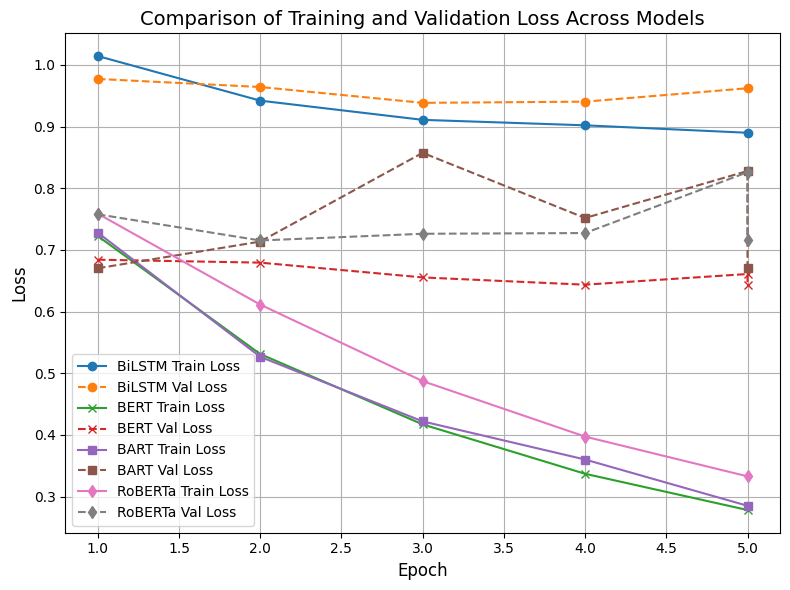

In [26]:
import matplotlib.pyplot as plt

# Helper function to extract epochs and loss values from trainer logs
def extract_logs(log_history):
    """
    Iterates through a log history list to extract epochs, training losses, 
    and evaluation (validation) losses.
    
    Returns:
        train_epochs: List of epochs with training loss.
        train_losses: List of training loss values.
        eval_epochs: List of epochs with evaluation loss.
        eval_losses: List of evaluation loss values.
    """
    train_epochs, train_losses = [], []
    eval_epochs, eval_losses = [], []
    
    for entry in log_history:
        if "epoch" in entry:
            epoch = entry["epoch"]
            # Check for training loss entries
            if "loss" in entry:
                train_epochs.append(epoch)
                train_losses.append(entry["loss"])
            # Check for evaluation loss entries
            if "eval_loss" in entry:
                eval_epochs.append(epoch)
                eval_losses.append(entry["eval_loss"])
    return train_epochs, train_losses, eval_epochs, eval_losses

# Function to plot training and validation losses for all four models
def plot_model_losses(custom_metrics, bert_log, bart_log, roberta_log):
    """
    Plots loss curves for a custom BiLSTM model along with three transformer-based
    models: BERT, BART, and RoBERTa.
    
    Args:
        custom_metrics: Dictionary containing "train_loss" and "val_loss" for BiLSTM.
        bert_log: Log history from the BERT fine-tuning process.
        bart_log: Log history from the BART fine-tuning process.
        roberta_log: Log history from the RoBERTa fine-tuning process.
    """
    plt.figure(figsize=(8, 6))
    
    # Plot for the custom BiLSTM model
    epochs_custom = range(1, len(custom_metrics["train_loss"]) + 1)
    plt.plot(epochs_custom, custom_metrics["train_loss"], marker="o", linestyle="-", label="BiLSTM Train Loss")
    plt.plot(epochs_custom, custom_metrics["val_loss"], marker="o", linestyle="--", label="BiLSTM Val Loss")
    
    # Parse logs for transformer models
    bert_train_epochs, bert_train_loss, bert_eval_epochs, bert_val_loss = extract_logs(bert_log)
    bart_train_epochs, bart_train_loss, bart_eval_epochs, bart_val_loss = extract_logs(bart_log)
    roberta_train_epochs, roberta_train_loss, roberta_eval_epochs, roberta_val_loss = extract_logs(roberta_log)
    
    # Plot for BERT
    plt.plot(bert_train_epochs, bert_train_loss, marker="x", linestyle="-", label="BERT Train Loss")
    plt.plot(bert_eval_epochs, bert_val_loss, marker="x", linestyle="--", label="BERT Val Loss")
    
    # Plot for BART
    plt.plot(bart_train_epochs, bart_train_loss, marker="s", linestyle="-", label="BART Train Loss")
    plt.plot(bart_eval_epochs, bart_val_loss, marker="s", linestyle="--", label="BART Val Loss")
    
    # Plot for RoBERTa
    plt.plot(roberta_train_epochs, roberta_train_loss, marker="d", linestyle="-", label="RoBERTa Train Loss")
    plt.plot(roberta_eval_epochs, roberta_val_loss, marker="d", linestyle="--", label="RoBERTa Val Loss")
    
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title("Comparison of Training and Validation Loss Across Models", fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Print evaluation metrics for all models
print("BiLSTM Validation Accuracy:", bilstm_metrics["val_acc"][-1])
print("**********************************************************************************\n")
print("BERT Evaluation Metrics:", bert_eval_metrics)
print("**********************************************************************************\n")
print("BART Evaluation Metrics:", bart_eval_metrics)
print("**********************************************************************************\n")
print("RoBERTa Evaluation Metrics:", roberta_eval_metrics)
print("**********************************************************************************\n")

# Generate a combined plot comparing the loss curves for all models
plot_model_losses(metrics, bert_logs, bart_logs, roberta_logs)


In [27]:
# Print evaluation metrics for all models
print("BiLSTM Validation Accuracy:", bilstm_metrics["val_acc"][-1])
print("**********************************************************************************\n")

print("BERT Evaluation Metrics:", bert_eval_metrics)
print("**********************************************************************************\n")

print("BART Evaluation Metrics:", bart_eval_metrics)
print("**********************************************************************************\n")

print("RoBERTa Evaluation Metrics:", roberta_eval_metrics)



BiLSTM Validation Accuracy: 0.6145552560646901
**********************************************************************************

BERT Evaluation Metrics: {'eval_loss': 0.6435721516609192, 'eval_accuracy': 0.7358490566037735, 'eval_f1': 0.7074912090440041, 'eval_runtime': 2.2709, 'eval_samples_per_second': 163.37, 'eval_steps_per_second': 10.568, 'epoch': 5.0}
**********************************************************************************

BART Evaluation Metrics: {'eval_loss': 0.6702509522438049, 'eval_accuracy': 0.24258760107816713, 'eval_f1': 0.1301518438177874, 'eval_runtime': 10.7897, 'eval_samples_per_second': 34.385, 'eval_steps_per_second': 2.224, 'epoch': 5.0}
**********************************************************************************

RoBERTa Evaluation Metrics: {'eval_loss': 0.7152996063232422, 'eval_accuracy': 0.7277628032345014, 'eval_f1': 0.66986116249757, 'eval_runtime': 2.3396, 'eval_samples_per_second': 158.576, 'eval_steps_per_second': 10.258, 'epoch': 5.0}

In [29]:
import shutil

# Zip all output files
shutil.make_archive('/kaggle/working/all_outputs', 'zip', '/kaggle/working')

print("Zipping complete! You can now download the 'all_outputs.zip' file from the Kaggle UI.")


OSError: [Errno 28] No space left on device